# Seguimos con el modelado de las funciones sinusoidales usando redes neuronales

En este caso vamos a utilizar una red neuronal recurrente RNN

In [1]:
using Flux
using Flux: train!
using Flux.Losses: mse
using Statistics
using Plots
using Distributions
using ProgressMeter

Para estas redes se utilizan secuencias para el aprendizaje de la red, para ello vamos a tomar un intervalo de 10 en una escala de tiempo y vamos a dejar que la red prediga en el valor en el paso 11 y así.
Primero que todo creamos las secuencias de entrenamiento

In [2]:
function data_maker(x, len_seq)
    N = length(x)
    X = []
    Y = []
    while N > 0
        if (N - len_seq) <= 0
            break
        end
        vec = [[xi] for xi in x[N - len_seq:N-1]]
        #println(typeof(vec))
        vec_end = [[x[N]]]
        push!(X, vec)
        push!(Y, vec_end)
        N -= len_seq + 1 
    end
    return Vector{Vector{Float32}}.(X), Vector{Vector{Float32}}.(Y)
end

data_maker (generic function with 1 method)

In [3]:
len_sequence = 10
t_train = hcat(0:0.05:20)
t_train = Float32.(t_train)
t_train = t_train[1:end]
t_train_data, t_test_data = data_maker(t_train, len_sequence)

(Vector{Vector{Float32}}[[[19.5], [19.55], [19.6], [19.65], [19.7], [19.75], [19.8], [19.85], [19.9], [19.95]], [[18.95], [19.0], [19.05], [19.1], [19.15], [19.2], [19.25], [19.3], [19.35], [19.4]], [[18.4], [18.45], [18.5], [18.55], [18.6], [18.65], [18.7], [18.75], [18.8], [18.85]], [[17.85], [17.9], [17.95], [18.0], [18.05], [18.1], [18.15], [18.2], [18.25], [18.3]], [[17.3], [17.35], [17.4], [17.45], [17.5], [17.55], [17.6], [17.65], [17.7], [17.75]], [[16.75], [16.8], [16.85], [16.9], [16.95], [17.0], [17.05], [17.1], [17.15], [17.2]], [[16.2], [16.25], [16.3], [16.35], [16.4], [16.45], [16.5], [16.55], [16.6], [16.65]], [[15.65], [15.7], [15.75], [15.8], [15.85], [15.9], [15.95], [16.0], [16.05], [16.1]], [[15.1], [15.15], [15.2], [15.25], [15.3], [15.35], [15.4], [15.45], [15.5], [15.55]], [[14.55], [14.6], [14.65], [14.7], [14.75], [14.8], [14.85], [14.9], [14.95], [15.0]]  …  [[5.2], [5.25], [5.3], [5.35], [5.4], [5.45], [5.5], [5.55], [5.6], [5.65]], [[4.65], [4.7], [4.75], [

Otra vez tenenmos la función seno con ruido

In [4]:
function Noise_Sine(x)
    return sin(x) + rand(Normal(0,0.1))
end

Noise_Sine (generic function with 1 method)

In [5]:
y_train = Noise_Sine.(t_train)
y_train = Float32.(y_train)
y_train = y_train[1:end]
y_train_data, y_test_data = data_maker(y_train, len_sequence)

(Vector{Vector{Float32}}[[[0.61942095], [0.42039695], [0.7115973], [0.6911949], [0.79158336], [0.81169766], [0.78106904], [0.7102294], [0.8586292], [0.7889621]], [[0.06486052], [-0.04464081], [0.2293797], [0.23819785], [0.40325212], [0.2163507], [0.41180414], [0.41125146], [0.40920693], [0.47623277]], [[-0.41823986], [-0.4300866], [-0.23007245], [-0.44142696], [-0.13581178], [-0.18390934], [-0.09872898], [-0.00812279], [-0.10225988], [0.060583424]], [[-0.91610307], [-0.77013034], [-0.6478167], [-0.8012807], [-0.70062494], [-0.5059194], [-0.83232564], [-0.55761886], [-0.550488], [-0.63462424]], [[-0.9909547], [-0.9732268], [-0.7391709], [-0.9618716], [-0.97082275], [-0.9219011], [-0.90518653], [-1.0363159], [-0.842608], [-0.8202292]], [[-0.77193576], [-0.91759986], [-0.88243717], [-0.7809265], [-1.0032514], [-0.99940336], [-1.0495887], [-0.9891746], [-1.0655841], [-1.1185129]], [[-0.47286573], [-0.4472827], [-0.42637655], [-0.7474321], [-0.65475386], [-0.67763764], [-0.61426437], [-0.74

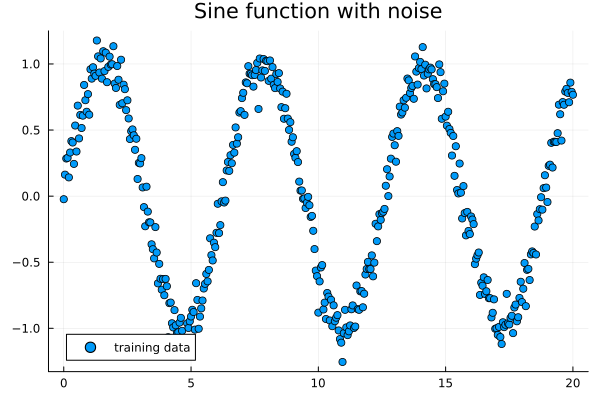

In [6]:
scatter(t_train, y_train, label="training data", title="Sine function with noise")

Creemos el modelo en el cual vamos a usar una capa RNN con 30 neuronas y una capa densa con una neurona de salida

In [7]:
modelRNN = Chain(RNN(1 => 50), LSTM(50,30) , Dense(30 => 1))

Chain(
  Recur(
    RNNCell(1 => 50, tanh),             # 2_650 parameters
  ),
  Recur(
    LSTMCell(50 => 30),                 # 9_780 parameters
  ),
  Dense(30 => 1),                       # 31 parameters
)         # Total: 11 trainable arrays, 12_461 parameters,
          # plus 3 non-trainable, 110 parameters, summarysize 49.379 KiB.

Además creamos la función loss donde ponemos un reset cada vez que termina una secuencia

In [8]:
function loss(x, y)
    sum(mse(modelRNN(xi), yi) for (xi, yi) in zip(x, y))
  end

loss (generic function with 1 method)

Ahora agrupemos los datos para ser entrenados

In [9]:
data = zip(t_train_data,y_train_data)

zip(Vector{Vector{Float32}}[[[19.5], [19.55], [19.6], [19.65], [19.7], [19.75], [19.8], [19.85], [19.9], [19.95]], [[18.95], [19.0], [19.05], [19.1], [19.15], [19.2], [19.25], [19.3], [19.35], [19.4]], [[18.4], [18.45], [18.5], [18.55], [18.6], [18.65], [18.7], [18.75], [18.8], [18.85]], [[17.85], [17.9], [17.95], [18.0], [18.05], [18.1], [18.15], [18.2], [18.25], [18.3]], [[17.3], [17.35], [17.4], [17.45], [17.5], [17.55], [17.6], [17.65], [17.7], [17.75]], [[16.75], [16.8], [16.85], [16.9], [16.95], [17.0], [17.05], [17.1], [17.15], [17.2]], [[16.2], [16.25], [16.3], [16.35], [16.4], [16.45], [16.5], [16.55], [16.6], [16.65]], [[15.65], [15.7], [15.75], [15.8], [15.85], [15.9], [15.95], [16.0], [16.05], [16.1]], [[15.1], [15.15], [15.2], [15.25], [15.3], [15.35], [15.4], [15.45], [15.5], [15.55]], [[14.55], [14.6], [14.65], [14.7], [14.75], [14.8], [14.85], [14.9], [14.95], [15.0]]  …  [[5.2], [5.25], [5.3], [5.35], [5.4], [5.45], [5.5], [5.55], [5.6], [5.65]], [[4.65], [4.7], [4.75]

Guardamos los parámetros y el método de optimización

In [10]:
ps = Flux.params(modelRNN)
opt= Adam(1e-3)

Adam(0.001, (0.9, 0.999), 1.0e-8, IdDict{Any, Any}())

In [11]:
for _ in 1:100
    Flux.train!(loss, ps, data, opt)
end

In [12]:
function Plotall()
    pl = scatter([x[1] for x in t_train_data[1]], [x[1] for x in y_train_data[1]], label="Data",color = "red")
    scatter!([x[1] for x in t_train_data[1]], [modelRNN(x)[1] for x in t_train_data[1]], label="Prediction",color = "blue")
    for i in 2:length(t_train_data)
        scatter!([x[1] for x in t_train_data[i]], [x[1] for x in y_train_data[i]],color = "red",label = false)
        scatter!([x[1] for x in t_train_data[i]], [modelRNN(x)[1] for x in t_train_data[i]],color = "blue",label = false)
    end
    savefig(pl,"file.png")
    pl
end

Plotall (generic function with 1 method)

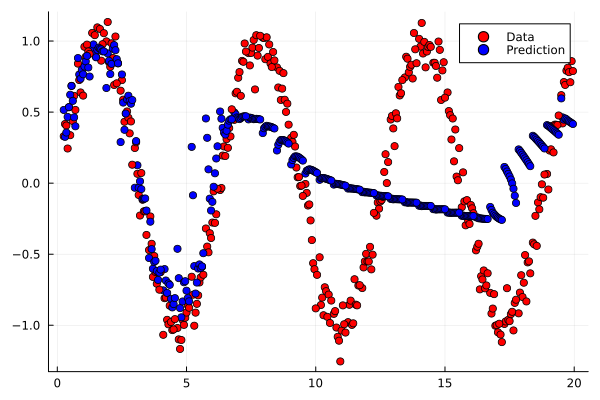

In [13]:
Plotall()

Si nos fijamos la red predice los valores bien en un rango, pero necesita mucho mas entrenamiento que una red convencional, no pude mejorar esta red.